### <b><center>Signal Image and Video Processing</center></b>
<b><center><i>Exam Project</i></center></b>
<br>
### Title:<b> Real-time Liveness Detection: Ensuring the Integrity of Facial Recognition Systems</b>

A Course Project as part of course final exam Submitted By:
<br>
1. __Adnan Irshad__
    - Reg # 241763
2. __Hira Afzal__
    - Reg # 241351
    
To Course Professors:
1. __Professor Francesco De Natale__
2. __Professor Andrea Rosani__


### Abstract
In the face recognition system, one of the common problems that arise are presentation attacks or spoofing attacks, which raises questions about the performance and reliability of face recognition-based systems for ensuring access & security. To tackle this issue, this project proposes an extra security layer of face anti-spoofing in the face recognition process through the implementation of face liveness detection in real time. The proposed system uses two anti-spoofing techniques: Motion analysis by eyes blinks detection & mouth movement/speaking detection and color texture analysis by color models techniques. Motion analysis approach is suitable for detecting only image-based spoofing attacks, but it fails in video-based spoofing attacks. Therefore, along with motion analysis approach, texture analysis approach by using colorspaces technique is used to ensure more robust anti-spoofing protection against mobile image, mobile replay and printed image spoofing attacks. The proposed system uses Eyes/Mouth movements detection along with the YCrCb and CIEluv color spaces to detect face liveness and then combines both histograms of these color spaces into a single feature set, which is used as input to a support vector machine (SVM) classifier for liveness prediction.

#### Project Flow Diagram

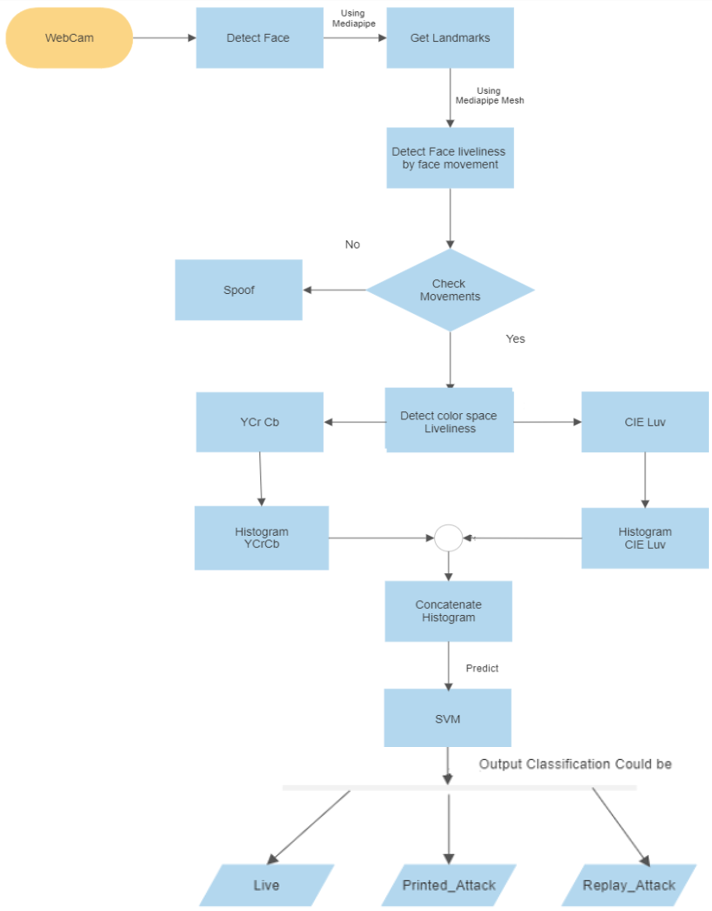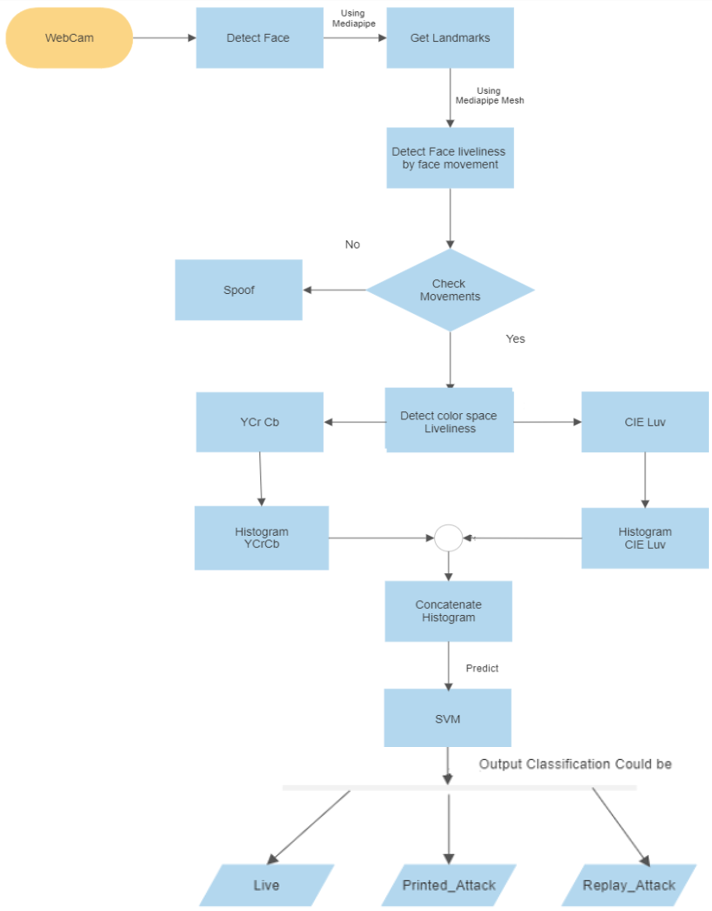

### Liveness Detection Method-1: Motion Analysis

In the motion analysis approach, eye blink and mouth/jaws open/close movements are used as cues to determine whether a face is live or not. The idea behind this approach is that a live face should show dynamic movements, such as eye blinks or mouth open/close/speaking movements, while a fake face, such as a photograph or a mask, should remain static.

To detect eye blinks, the system can analyze changes in eye shape, eye closure duration, and the frequency of eye blinks. Similarly, the system can analyze changes in the shape of the mouth region, such as lip movements, to detect mouth open/close movements.
To detect eyes blinks & jaws movements in proposed system, the system detects the human face and then uses mediapipe to obtain the facial landmarks.

#### i) Face & Landmarks Detection

To detect the face and face landmarks, **MediaPipe** library is used.

Mediapipe is a machine learning framework developed by Google that provides a collection of pre-built models and tools for building real-time multimedia applications. It uses a variety of computer vision techniques, including convolutional neural networks (CNNs), to perform tasks such as face detection and face landmark detection.

**Face Detection:**
In Mediapipe, the face detection model is based on a single-shot detector (SSD) architecture that uses a deep neural network to predict the bounding boxes of faces in an image. In this project, we are using MediaPipe face detector to detect face from current frame or image, crop the face, resize it to **224 by 224** and also ensure that there are no multiple faces in specified face detection box.

**Face Landmarks Detection:**
Mediapipe's face landmarks detection model is based on a deep neural network that is trained to predict the coordinates of specific facial landmarks, such as the corners of the eyes, the nose, and the corners of the mouth. mp_face_mesh.FaceMesh function initializes the pre-trained face landmarks detection model and provides a convenient interface for processing images and videos to detect the facial landmarks.

After detecting face and face landmarks, we extracted the Eyes landmarks indexes, upper lips and lower lips landmarks indexes as per following diagram:

##### Eyes Landmarks Indexes:
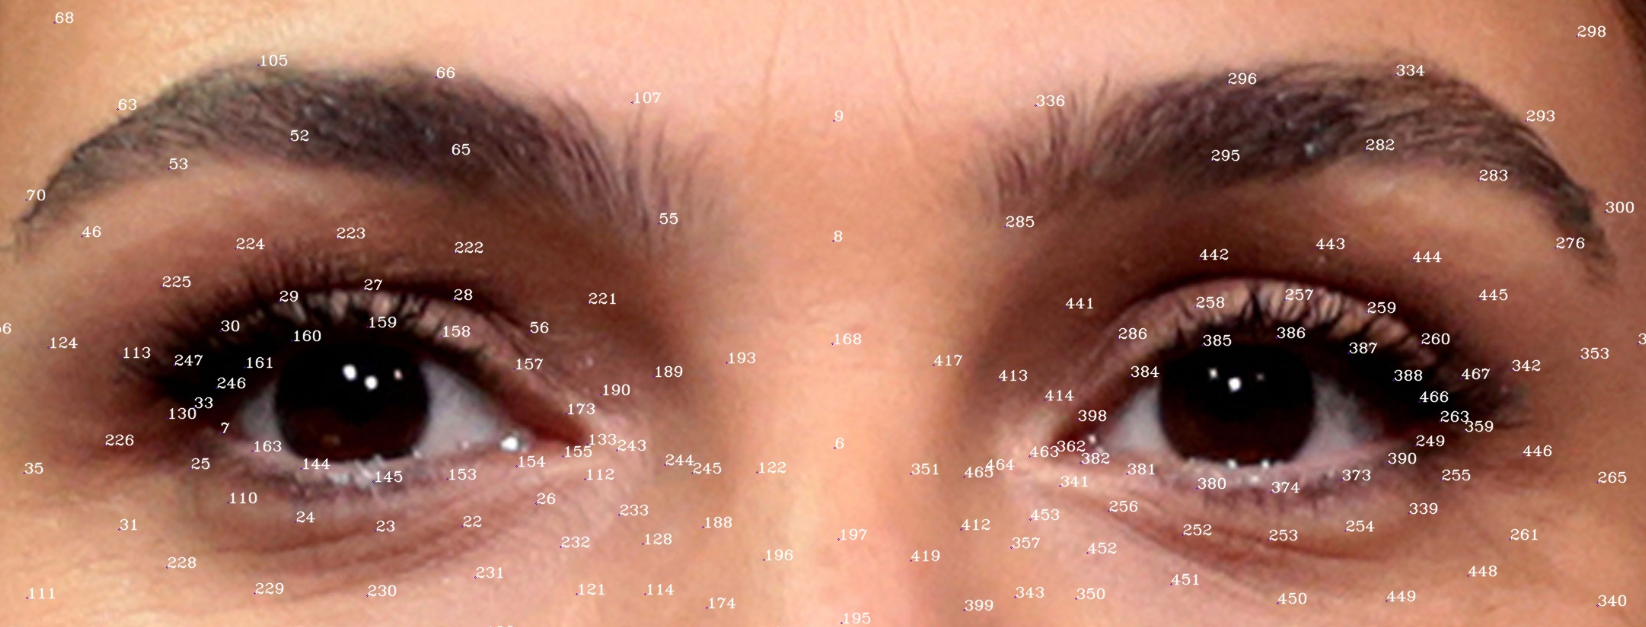

LEFT_EYE = [362, 382, 381, 380, 374, 373, 390, 249, 263, 466, 388, 387, 386, 385, 384, 398]

RIGHT_EYE = [33, 7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158, 159, 160, 161, 246]

##### Lips Landmarks Indexes:
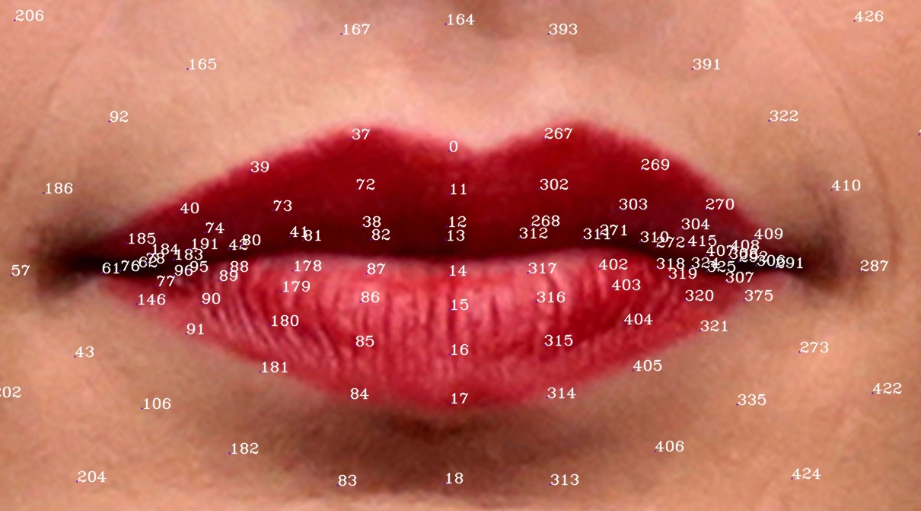

LOWER_LIPS = [61, 146, 91, 181, 84, 17, 314, 405, 321, 375, 291, 308, 324, 318, 402, 317, 14, 87, 178, 88, 95]

UPPER_LIPS = [185, 40, 39, 37, 0, 267, 269, 270, 409, 415, 310, 311, 312, 13, 82, 81, 42, 183, 78]

#### ii) Eyes Blinks Detection 
Using the ayes 6 landmarks position, and calculates the eye aspect ratio (EAR) by dividing the distance between the eyes by the width of the face using the formula written below and image shown below:

*EAR = (||p2-p6||+||p3-p5||)/(2||p1-p4||)*

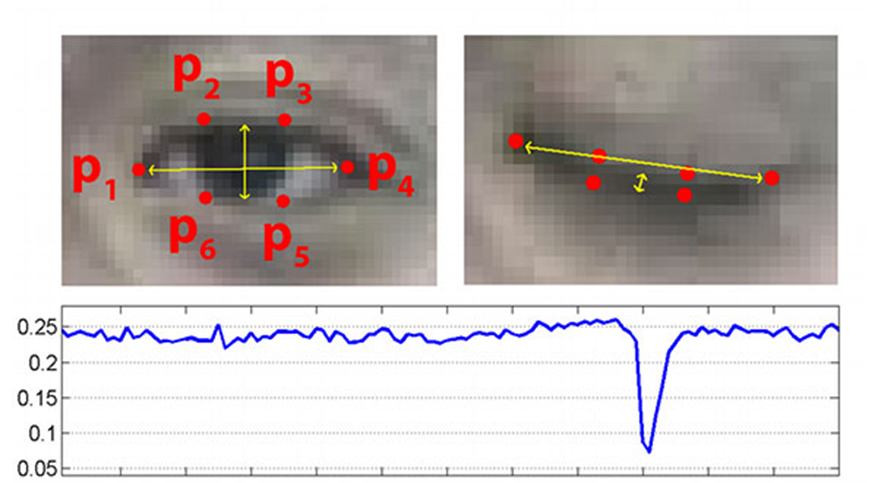

In [ ]:
def blink_ratio(landmarks, right_indices, left_indices):
    """
    Calculate the eye aspect ratio by calculating the euclidean distance between the horizontal and vertical
    landmarks of the  eyes and then dividing the horizontal distance by the vertical distance.
    Finally adding the ratio of the left eye and the right eye and dividing by 2 to get the average ratio.
    :param landmarks: landmark pixels coordinates extracted from the face
    :param right_indices: right eye indices list
    :param left_indices: left eye indices list
    :return: eye aspect ratio
    """
    # RIGHT_EYE
    # horizontal line
    rh_right = landmarks[right_indices[0]]
    rh_left = landmarks[right_indices[8]]

    # vertical line
    rv_top = landmarks[right_indices[12]]
    rv_bottom = landmarks[right_indices[4]]

    # LEFT_EYE
    # horizontal line
    lh_right = landmarks[left_indices[0]]
    lh_left = landmarks[left_indices[8]]

    # vertical line
    lv_top = landmarks[left_indices[12]]
    lv_bottom = landmarks[left_indices[4]]

    rh_distance = euclidean_distance(rh_right, rh_left)
    rv_distance = euclidean_distance(rv_top, rv_bottom)

    lv_distance = euclidean_distance(lv_top, lv_bottom)
    lh_distance = euclidean_distance(lh_right, lh_left)

    re_ratio = rh_distance / rv_distance
    le_ratio = lh_distance / lv_distance

    ratio_ = (re_ratio + le_ratio) / 2
    return ratio_

**Mouth Open/Close or Speaking Detection:** While the mouth aspect ratio (MAR), like EAR goes up when there are movements in jaws like open the mouth or speak.

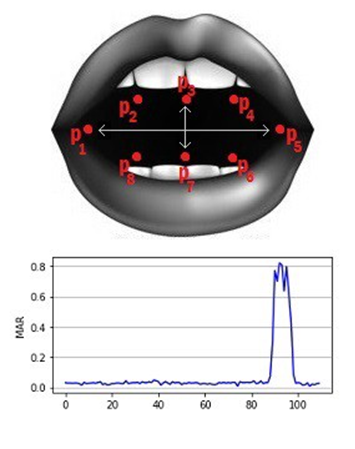

The system then uses these ratios to determine if the eyes are closed or open and if the mouth is open or closed. If the eye aspect ratio is lower than a certain threshold, it indicates that the eyes are closed, and if the mouth aspect ratio is higher than a certain threshold, it indicates that the mouth is open. These movements, along with color information from the color spaces, are then used to determine the liveness of the face.

In [ ]:
def mouth_ratio(landmarks, lower_lip_indices, upper_lip_indices):
    """
    Calculate the mouth aspect ratio by calculating the euclidean distance between the horizontal and vertical
    landmarks of the mouth and then dividing the horizontal distance by the vertical distance.
    :param landmarks: landmark pixels coordinates extracted from the face
    :param lower_lip_indices: lower lip indices list
    :param upper_lip_indices: upper lip indices list
    :return: mouth aspect ratio
    """
    # horizontal line
    rh_right = landmarks[lower_lip_indices[0]]
    rh_left = landmarks[lower_lip_indices[8]]
    # vertical line
    rv_top = landmarks[upper_lip_indices[6]]
    rv_bottom = landmarks[lower_lip_indices[6]]

    rh_distance = euclidean_distance(rh_right, rh_left)
    rv_distance = euclidean_distance(rv_top, rv_bottom)

    ratio_ = rh_distance / rv_distance
    return ratio_

### Liveness Detection Method-2: Color Texture Analysis

### Color Texture Analysis Methodology

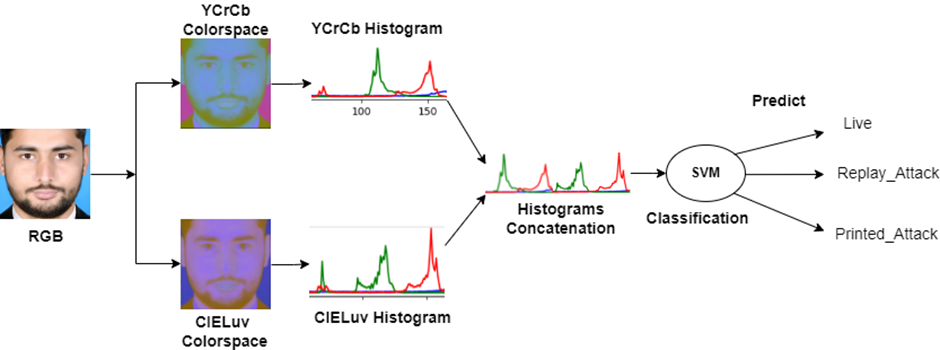

### Dataset Preparation

Since majority databases like CASIA Face Anti-Spoofing and Replay-Attack datasets were private and needed access to train & evaluate classifier, we created our own custom dataset by taking 15 to 20 seconds of videos with different poses and lightening conditions of each case including live face, live replay attack, mobile photo attack, printed image and photo of printed image. Apart from this we also gathered some publicly available datasets as well to prevent bias datasets. After gathering dataset and recording our own videos, we performed preprocessing operations including converting videos into frames, extracting face from frames & cropping faces, and splitting into training and testing datasets. We trained our face liveness classifier on 5957 training images and 1491 testing images. There were a total of three classes including 2555 images of printed attack, 757 images of replay attack and 2645 images of real/live faces.

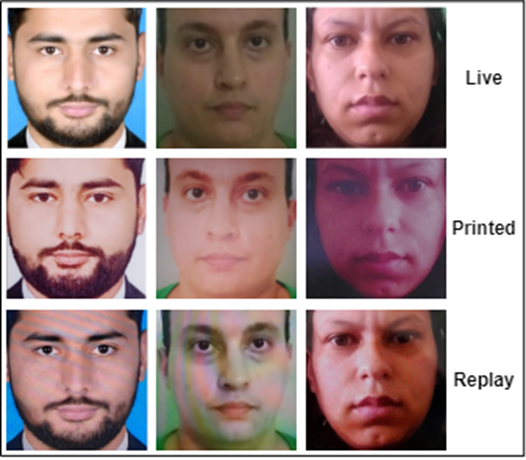

### Getting Insights and Understanding Proposed Methodology 

### Importing libraries

In [ ]:
import warnings
# ignore all future warnings from sklearn
warnings.simplefilter(action='ignore', category=FutureWarning)
# ignore all warnings from sklearn
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")

from IPython.display import HTML
from IPython.display import Video

import cv2
import numpy as np
import os
import glob

from matplotlib import pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, average_precision_score, \
    precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve
import joblib

# import sklearn.metrics.confusion_matrix
from sklearn.metrics import confusion_matrix
# classification_report
from sklearn.metrics import classification_report

from sklearn.preprocessing import label_binarize

#### 1. Read Face Images

In [4]:
# load real, printed_attack, and replay_attack image and convert them to YCrCb & CIE L*u*v* color spaces
real_img = cv2.imread("report_support/real.jpg")
printed_attack_img = cv2.imread("report_support/printed_attack.jpg")
replay_attack_img = cv2.imread("report_support/replay_attack.jpg")

#### 2. Convert RGB face images(Real, Printed and Replay) in YCrCB and CIE Luv Colorspaces

In [5]:
printed_attack_img_ycrcb = cv2.cvtColor(printed_attack_img, cv2.COLOR_BGR2YCrCb)
printed_attack_img_luv = cv2.cvtColor(printed_attack_img, cv2.COLOR_BGR2Luv)

real_img_ycrcb = cv2.cvtColor(real_img, cv2.COLOR_BGR2YCrCb)
real_img_luv = cv2.cvtColor(real_img, cv2.COLOR_BGR2Luv)

replay_attack_img_ycrcb = cv2.cvtColor(replay_attack_img, cv2.COLOR_BGR2YCrCb)
replay_attack_img_luv = cv2.cvtColor(replay_attack_img, cv2.COLOR_BGR2Luv)

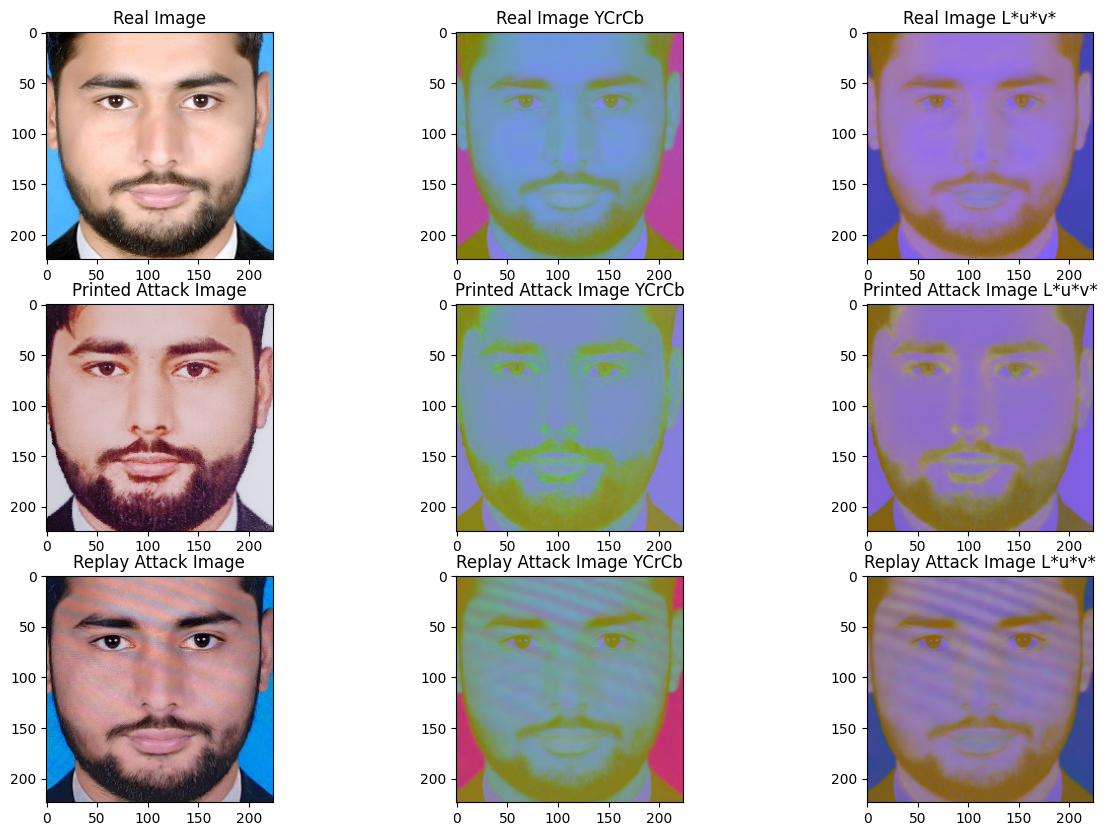

In [6]:
# display the real, printed_attack, and replay_attack images along with their YCrCb & CIE L*u*v* color spaces images in a 3x3 grid
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
axs[0, 0].imshow(cv2.cvtColor(real_img, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('Real Image')
axs[0, 1].imshow(cv2.cvtColor(real_img_ycrcb, cv2.COLOR_BGR2RGB))
axs[0, 1].set_title('Real Image YCrCb')
axs[0, 2].imshow(cv2.cvtColor(real_img_luv, cv2.COLOR_BGR2RGB))
axs[0, 2].set_title('Real Image L*u*v*')
axs[1, 0].imshow(cv2.cvtColor(printed_attack_img, cv2.COLOR_BGR2RGB))
axs[1, 0].set_title('Printed Attack Image')
axs[1, 1].imshow(cv2.cvtColor(printed_attack_img_ycrcb, cv2.COLOR_BGR2RGB))
axs[1, 1].set_title('Printed Attack Image YCrCb')
axs[1, 2].imshow(cv2.cvtColor(printed_attack_img_luv, cv2.COLOR_BGR2RGB))
axs[1, 2].set_title('Printed Attack Image L*u*v*')
axs[2, 0].imshow(cv2.cvtColor(replay_attack_img, cv2.COLOR_BGR2RGB))
axs[2, 0].set_title('Replay Attack Image')
axs[2, 1].imshow(cv2.cvtColor(replay_attack_img_ycrcb, cv2.COLOR_BGR2RGB))
axs[2, 1].set_title('Replay Attack Image YCrCb')
axs[2, 2].imshow(cv2.cvtColor(replay_attack_img_luv, cv2.COLOR_BGR2RGB))
axs[2, 2].set_title('Replay Attack Image L*u*v*')
plt.show()

#### 4. Get the Histograms
Split YCrCb and CIELuv color spaces and calculate histograms (1 for each component of YCrCb and CIELuv color spaces) for real, printed and replay face.

In [7]:
# calculate the YCrCb histograms for real, printed_attack, and replay_attack images
real_y, real_cr, real_cb = cv2.split(real_img_ycrcb)
real_hist_y = cv2.calcHist([real_y], [0], None, [256], [0, 256])
real_hist_cr = cv2.calcHist([real_cr], [0], None, [256], [0, 256])
real_hist_cb = cv2.calcHist([real_cb], [0], None, [256], [0, 256])

printed_attack_y, printed_attack_cr, printed_attack_cb = cv2.split(printed_attack_img_ycrcb)
printed_attack_hist_y = cv2.calcHist([printed_attack_y], [0], None, [256], [0, 256])
printed_attack_hist_cr = cv2.calcHist([printed_attack_cr], [0], None, [256], [0, 256])
printed_attack_hist_cb = cv2.calcHist([printed_attack_cb], [0], None, [256], [0, 256])

replay_attack_y, replay_attack_cr, replay_attack_cb = cv2.split(replay_attack_img_ycrcb)
replay_attack_hist_y = cv2.calcHist([replay_attack_y], [0], None, [256], [0, 256])
replay_attack_hist_cr = cv2.calcHist([replay_attack_cr], [0], None, [256], [0, 256])
replay_attack_hist_cb = cv2.calcHist([replay_attack_cb], [0], None, [256], [0, 256])

# calculate the CIE L*u*v* histograms for real, printed_attack, and replay_attack images
real_l, real_u, real_v = cv2.split(real_img_luv)
real_hist_l = cv2.calcHist([real_l], [0], None, [256], [0, 256])
real_hist_u = cv2.calcHist([real_u], [0], None, [256], [0, 256])
real_hist_v = cv2.calcHist([real_v], [0], None, [256], [0, 256])

printed_attack_l, printed_attack_u, printed_attack_v = cv2.split(printed_attack_img_luv)
printed_attack_hist_l = cv2.calcHist([printed_attack_l], [0], None, [256], [0, 256])
printed_attack_hist_u = cv2.calcHist([printed_attack_u], [0], None, [256], [0, 256])
printed_attack_hist_v = cv2.calcHist([printed_attack_v], [0], None, [256], [0, 256])

replay_attack_l, replay_attack_u, replay_attack_v = cv2.split(replay_attack_img_luv)
replay_attack_hist_l = cv2.calcHist([replay_attack_l], [0], None, [256], [0, 256])
replay_attack_hist_u = cv2.calcHist([replay_attack_u], [0], None, [256], [0, 256])
replay_attack_hist_v = cv2.calcHist([replay_attack_v], [0], None, [256], [0, 256])

##### Plot the YCrCb histograms for faces

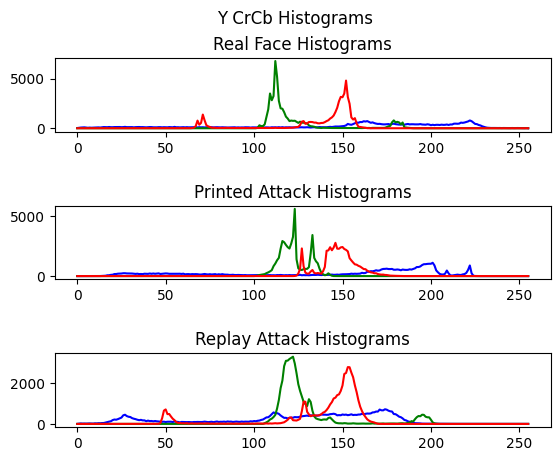

In [8]:
# plot the YCrCb histograms for real, printed_attack, and replay_attack images in one figure containing 3 subplots one for each image containing each of the 3 YCrCb histograms
plt.figure(1)
plt.subplot(311)
# add a space between the subplots
plt.subplots_adjust(hspace=1.0)
plt.plot(real_hist_y, color='b', label='Y')
plt.plot(real_hist_cb, color='g', label='Cb')
plt.plot(real_hist_cr, color='r', label='Cr')
plt.title('Real Face Histograms')

# add a space between the subplots
plt.subplots_adjust(hspace=1.0)

plt.subplot(312)
plt.plot(printed_attack_hist_y, color='b', label='Y')
plt.plot(printed_attack_hist_cb, color='g', label='Cb')
plt.plot(printed_attack_hist_cr, color='r', label='Cr')
plt.title('Printed Attack Histograms')

# add a space between the subplots
plt.subplots_adjust(hspace=1.0)

plt.subplot(313)
plt.plot(replay_attack_hist_y, color='b', label='Y')
plt.plot(replay_attack_hist_cb, color='g', label='Cb')
plt.plot(replay_attack_hist_cr, color='r', label='Cr')
plt.title('Replay Attack Histograms')
# title the figure
plt.suptitle('Y CrCb Histograms')
plt.show()

##### Plot the CIE L*u*v* histograms for faces

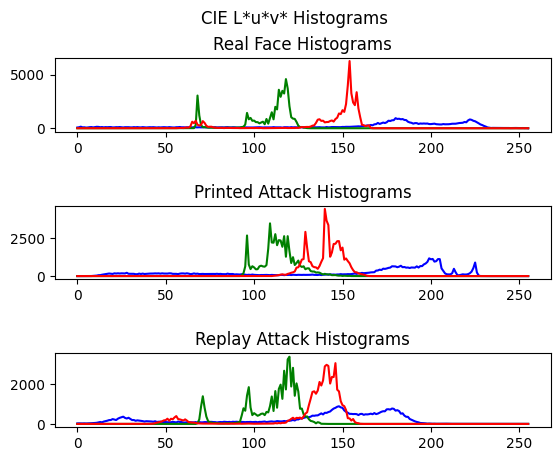

In [9]:
# plot the CIE L*u*v* histograms for real, printed_attack, and replay_attack images in one figure containing 3 subplots one for each image containing each of the 3 CIE L*u*v* histograms
plt.figure(2)
plt.subplot(311)
# add a space between the subplots
plt.subplots_adjust(hspace=1.0)
plt.plot(real_hist_l, color='b', label='L')
plt.plot(real_hist_u, color='g', label='u')
plt.plot(real_hist_v, color='r', label='v')
plt.title('Real Face Histograms')

# add a space between the subplots
plt.subplots_adjust(hspace=1.0)

plt.subplot(312)
plt.plot(printed_attack_hist_l, color='b', label='L')
plt.plot(printed_attack_hist_u, color='g', label='u')
plt.plot(printed_attack_hist_v, color='r', label='v')
plt.title('Printed Attack Histograms')

# add a space between the subplots
plt.subplots_adjust(hspace=1.0)

plt.subplot(313)
plt.plot(replay_attack_hist_l, color='b', label='L')
plt.plot(replay_attack_hist_u, color='g', label='u')
plt.plot(replay_attack_hist_v, color='r', label='v')
plt.title('Replay Attack Histograms')
# title the figure
plt.suptitle('CIE L*u*v* Histograms')
plt.show()

### Observations 

By observing histograms graphs for each image, can be seen that the luminance information in both color spaces has almost “regular shape” in the real face (which does not happen in the print attack and replay attack face images); regarding the chrominance histograms, the “regular shape”. It means that taking these insights and converting them into features vectors and training a classifier can be used to differentiate between the real/live, print attack and replay attack face images.

### Building Face Liveness Detection Classifier

In [10]:
# Function to load the dataset and extract the labels and images
def load_dataset(dataset_path_):
    images_ = []
    labels_ = []
    for folder in os.listdir(dataset_path_):
        for file in glob.glob(os.path.join(dataset_path_, folder, '*.jpg')):
            image = cv2.imread(file)
            images_.append(image)
            labels_.append(folder)
    return images_, labels_

In [11]:
# Function convert the images from RGB to YCrCb and CIE L*u*v* color spaces
def convert_color_spaces(images):
    """
    Convert the images from RGB to YCrCb and CIE L*u*v* color spaces
    :param images: list of images to be converted to the color spaces
    :return: list of images converted to the color spaces YCrCb and CIE L*u*v*
    """
    images_ycrcb = []
    images_luv = []
    for image in images:
        image_ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        image_luv = cv2.cvtColor(image, cv2.COLOR_BGR2Luv)
        images_ycrcb.append(image_ycrcb)
        images_luv.append(image_luv)

    return images_ycrcb, images_luv

In [12]:
# Function to extract the histograms from the images
def extract_histograms(images):
    """
    Extract the histograms from the images in the YCrCb and CIE L*u*v* color spaces and concatenate them.
    :param images: list of YCrCb and CIE L*u*v* images
    :return: list of concatenated histograms
    """
    histograms = []
    for image in images:
        # Y CrCb
        y, cr, cb = cv2.split(image)
        hist_y = cv2.calcHist([y], [0], None, [256], [0, 256])
        hist_cr = cv2.calcHist([cr], [0], None, [256], [0, 256])
        hist_cb = cv2.calcHist([cb], [0], None, [256], [0, 256])
        
        # CIE L*u*v*
        l, u, v = cv2.split(image)
        hist_l = cv2.calcHist([l], [0], None, [256], [0, 256])
        hist_u = cv2.calcHist([u], [0], None, [256], [0, 256])
        hist_v = cv2.calcHist([v], [0], None, [256], [0, 256])

        # Next, the six histograms are concatenated into a Feature Vector F V = (Y, Cr, Cb, L, u, v)
        # of size 1536 (six normalized histograms in the range of 0–255) that serve as input for
        # the Extra Trees Classifier - ETC
        hist = np.concatenate((hist_y, hist_cr, hist_cb, hist_l, hist_u, hist_v), axis=0)
        histograms.append(hist)

    return histograms

In [13]:
# Function to normalize the histograms
def normalize_histograms(histograms):
    """
    Normalize the histograms to the range of 0–1. This is done to avoid the bias of the classifier towards the
    larger values of the histogram.
    :param histograms: list of histograms to be normalized
    :return: list of normalized histograms
    """
    normalized_histograms = []
    for histogram in histograms:
        normalized_histogram = cv2.normalize(histogram, histogram, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX,
                                             dtype=cv2.CV_32F)
        normalized_histograms.append(normalized_histogram)
    return normalized_histograms

In [14]:
# Function extract the features from the images
def extract_features(images):
    """
    Extract the features from the images in the YCrCb and CIE L*u*v* color spaces, calculate the histograms and
    normalize them.
    :param faces_: list of images to be extracted the features
    :return: list of features extracted from the images as normalized histograms
    """
    images_yuv, images_yuv2 = convert_color_spaces(images)
    histograms = extract_histograms(images_yuv)
    normalized_histograms = normalize_histograms(histograms)
    return normalized_histograms

In [1]:
# train the SVM model using the extracted features and labels: Live, Printed_Attack and Replay_Attack
def train_model(features_, labels_):
    # model_ = ExtraTreesClassifier(n_estimators=10, random_state=0)
    # model_.fit(features_, labels_)

    model_ = SVC(kernel='linear', probability=True)
    model_.fit(features_, labels_)

    return model_

#### 1. Load the Dataset

In [16]:
# path to the training dataset
train_dataset_path = os.path.join(os.getcwd(), 'custom_dataset', 'train')
# path to the test dataset
test_dataset_path = os.path.join(os.getcwd(), 'custom_dataset', 'test')

# load the training dataset
print('Loading the training dataset...')
train_images, train_labels = load_dataset(train_dataset_path)
# load the test dataset
print('Loading the test dataset...')
test_images, test_labels = load_dataset(test_dataset_path)
print('Dataset loaded successfully...')

Loading the training dataset...
Loading the test dataset...
Dataset loaded successfully...


In [17]:
print('Training images: ', len(train_images))
print('Training labels: ', len(train_labels))

print('\nTesting images: ', len(test_images))
print('Testing labels: ', len(test_labels))

print("\nNo. of Classes: ", len(set(train_labels)))
for i in set(train_labels):
    print(i, ":", train_labels.count(i), " images.")

Training images:  5957
Training labels:  5957

Testing images:  1491
Testing labels:  1491

No. of Classes:  3
Replay_Attack : 757  images.
Live : 2645  images.
Printed_Attack : 2555  images.


### 2. Extracting Features
- Convert Images into YCrCb colorspace image.
- Convert Images into CIE Luv colorspace image.
- Calculate histograms of YCrCb & CIE Luv colorscolorspaces.
- Concatenate calculated histograms

In [18]:
# extract the features from the training images
print("Extracting features from the training images...")
train_features = extract_features(train_images)

# extract the features from the test images
print("Extracting features from the test images...")
test_features = extract_features(test_images)
print("Completed.")

Extracting features from the training images...
Extracting features from the test images...
Completed.


In [19]:
# save the training features and labels
print("Saving the features and labels for training dataset...")
np.save('train_features.npy', train_features)
np.save('train_labels.npy', train_labels)

# save the test features and labels
print("Saving the features and labels for test dataset...")
np.save('test_features.npy', test_features)
np.save('test_labels.npy', test_labels)
print("Completed.")

Saving the features and labels for training dataset...
Saving the features and labels for test dataset...
Completed.


In [20]:
# load the training features and labels
print("Loading the features and labels for training dataset...")
train_features = np.load('train_features.npy')
train_features = train_features.reshape(-1, train_features.shape[1])
train_labels = np.load('train_labels.npy')

# load the test features and labels
print("Loading the features and labels for test dataset...")
test_features = np.load('test_features.npy')
test_features = test_features.reshape(-1, test_features.shape[1])
test_labels = np.load('test_labels.npy')
print("Loaded.")

Loading the features and labels for training dataset...
Loading the features and labels for test dataset...
Loaded.


### 3. Training Face Liveness Classifier

In [30]:
# train th model
print("Training the model...")
model = train_model(train_features, train_labels)
print("Model trained successfully...")

Training the model...
Model trained successfully...


In [31]:
# save the model
print("Saving the model...")
joblib.dump(model, 'model.pkl')
print("Model saved successfully...")

Saving the model...
Model saved successfully...


In [36]:
# load the model
print("Loading the trained model...")
model = joblib.load('model.pkl')
print("Model loaded successfully...")

Loading the trained model...
Model loaded successfully...


### 4. Evaluating Classifier

In [37]:
# load the training features and labels
print("Loading the features and labels for training dataset...")
train_features = np.load('train_features.npy')
train_features = train_features.reshape(-1, train_features.shape[1])
train_labels = np.load('train_labels.npy')

# load the test features and labels
print("Loading the features and labels for test dataset...")
test_features = np.load('test_features.npy')
test_features = test_features.reshape(-1, test_features.shape[1])
test_labels = np.load('test_labels.npy')

print("Loaded.")

Loading the features and labels for training dataset...
Loading the features and labels for test dataset...
Loaded.


In [38]:
# perform trained model evaluation on the test dataset using the extracted features and labels from the test dataset
predicted_labels = model.predict(test_features)

In [39]:
# calculate the training accuracy
train_accuracy = model.score(train_features, train_labels)
print('Training Accuracy: ', train_accuracy)

# calculate the test accuracy
test_accuracy = accuracy_score(test_labels, predicted_labels)
print('Test Accuracy: ', test_accuracy)

# calculate the precision
precision = precision_score(test_labels, predicted_labels, average='weighted')
print('Precision: ', precision)

# calculate the recall
recall = recall_score(test_labels, predicted_labels, average='weighted')
print('Recall: ', recall)

# calculate the f1 score
f1 = f1_score(test_labels, predicted_labels, average='weighted')
print('F1 Score: ', f1)

# evaluate the model using 10-fold cross-validation
scores = cross_val_score(model, train_features, train_labels, cv=10)
print('Cross-Validation Mean Score: ', scores.mean())

Training Accuracy:  1.0
Test Accuracy:  0.9450033534540577
Precision:  0.9477778302625601
Recall:  0.9450033534540577
F1 Score:  0.9443045427902744
Cross-Validation Mean Score:  0.911867632959224


In [40]:
# calculate the classification report
classification_report_ = classification_report(test_labels, predicted_labels)
print('Classification Report: ', classification_report_)

Classification Report:                  precision    recall  f1-score   support

          Live       0.97      0.95      0.96       662
Printed_Attack       0.91      0.99      0.95       639
 Replay_Attack       1.00      0.80      0.89       190

      accuracy                           0.95      1491
     macro avg       0.96      0.91      0.93      1491
  weighted avg       0.95      0.95      0.94      1491



In [41]:
def draw_confusion_matrix(test_labels_, predicted_labels_, classes_):
    """Draw the confusion matrix for the test dataset"""
    cm = confusion_matrix(test_labels_, predicted_labels_)
    print(cm)
    # show the confusion matrix with percentage of predictions made for each class
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks_ = np.arange(len(classes_))
    plt.xticks(tick_marks_, classes_, rotation=45)
    plt.yticks(tick_marks_, classes_)
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

[[627  35   0]
 [  9 630   0]
 [ 12  26 152]]


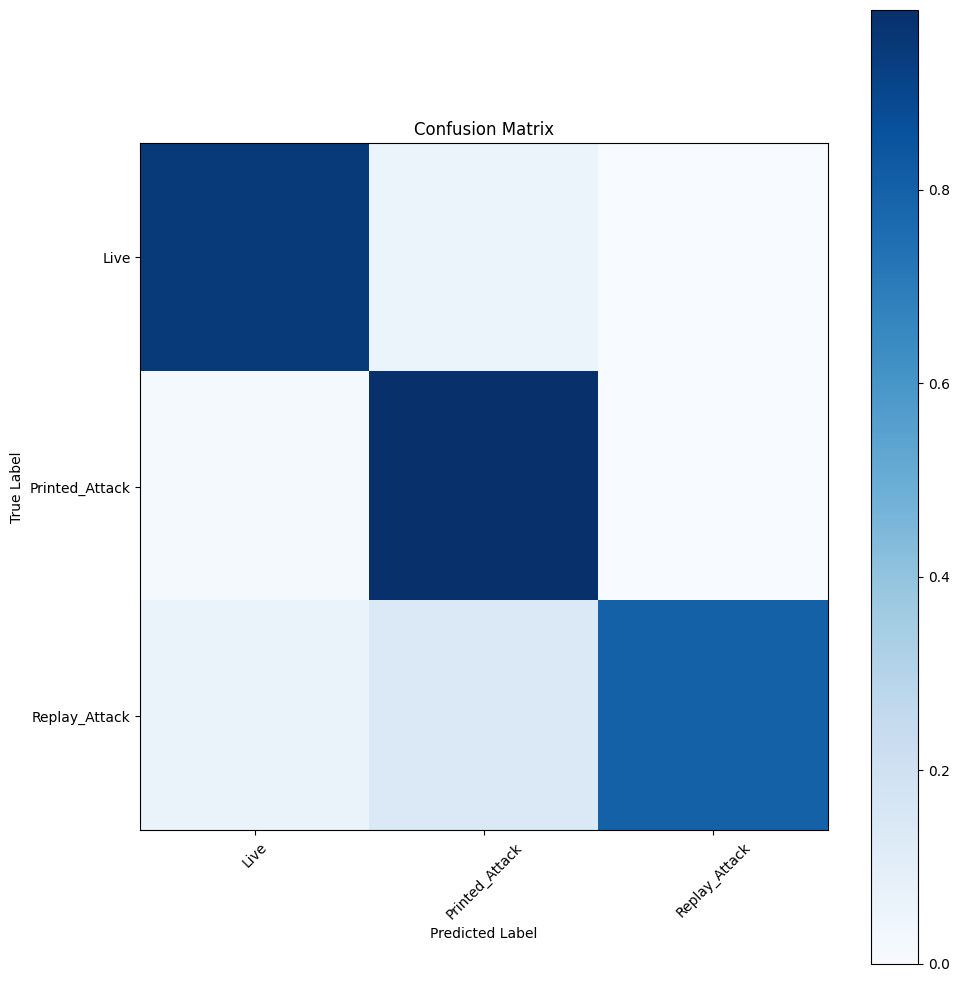

In [42]:
draw_confusion_matrix(test_labels, predicted_labels, model.classes_)

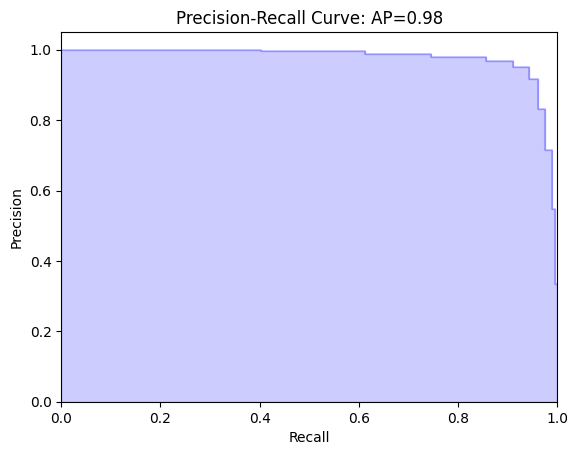

In [43]:
def draw_precision_recall_curve(test_labels_, predicted_probabilities_, classes_):
    # convert test_labels into a binary matrix
    test_labels_ = label_binarize(test_labels_, classes=classes_)
    # calculate the precision and recall for each class
    precision_, recall_, _ = precision_recall_curve(test_labels_.ravel(), predicted_probabilities_.ravel())
    # calculate the average precision for each class
    average_precision_ = average_precision_score(test_labels_, predicted_probabilities_, average='weighted')
    # plot the precision-recall curve for each class
    plt.figure()
    plt.step(recall_, precision_, color='b', alpha=0.2, where='post')
    plt.fill_between(recall_, precision_, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve: AP={0:0.2f}'.format(average_precision_))
    plt.show()


predicted_probabilities = model.predict_proba(test_features)
draw_precision_recall_curve(test_labels, predicted_probabilities, model.classes_)

### 5. Making Predictions on Unseen Faces

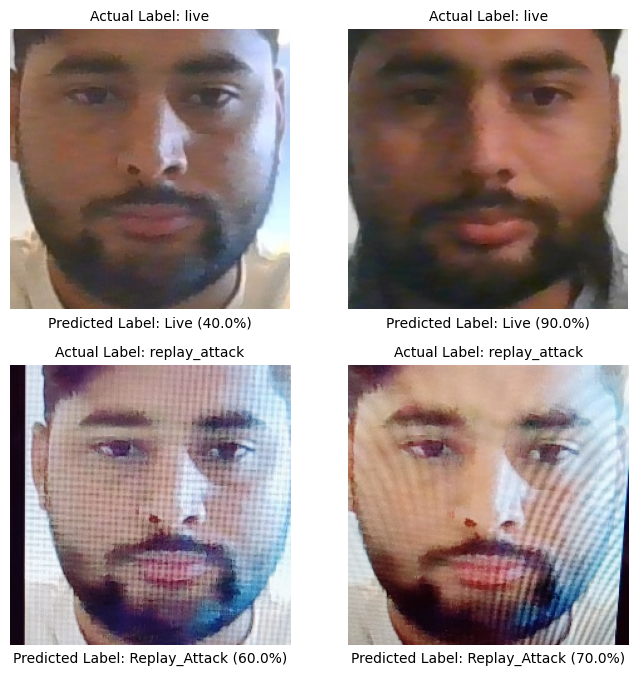

In [102]:
# do evaluation on unseen images
eval_folder = os.path.join(os.getcwd(), 'evaluation_faces')

eval_images = []
eval_labels = []
for file in glob.glob(os.path.join(eval_folder, '*.jpg')):
    image = cv2.imread(file)
    eval_images.append(image)
    eval_labels.append(os.path.basename(file).split('.')[0])

predictions_results = []
for tst_img in eval_images:
    # get the features from the image
    tst_features = extract_features([tst_img])
    tst_features = tst_features[0].reshape(-1, tst_features[0].shape[0])

    # predict the label
    predicted_label = model.predict(tst_features)
    predictions_results.append((predicted_label[0], np.max(model.predict_proba(tst_features))))
    
grid_size = len(eval_images)
grid_size = int(np.sqrt(grid_size))
fig = plt.figure(figsize=(8, 8))
for i in range(grid_size * grid_size):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.imshow(eval_images[i][:, :, ::-1])
    ax.set_title('Actual Label: ' + eval_labels[i].split('-')[0], fontsize=10)
    ax.text(0.5, -0.05, 'Predicted Label: ' + predictions_results[i][0] + f" ({predictions_results[i][1] * 100}%)", ha='center', va='center',  transform=ax.transAxes,
                fontsize=10)
    ax.axis('off')
plt.show()    

### 6. Testing on Web Cam in Real Time

In [7]:
Video("SIV Project Demo.mp4")

### 7. Conclusion

Our Project aims to address the problem of spoofing attacks in face recognition systems by proposing an extra security layer of face anti-spoofing through the implementation of real-time face liveness detection. In this project, we focused on mobile image, mobile replay/video and printed image based spoofing attacks. Our proposed methodology, uses two anti-spoofing techniques: Motion Analysis by eyes blinks detection & mouth/jaws movements/speaking detection and Color Space Histogram Concatenation, which are combined to provide robust anti-spoofing protection. The performance of the model is evaluated using metrics such as accuracy, precision, recall, and F1-score, confusion matrix, and classification report. The model tested in real-time using a webcam in real time. Overall, this project provides a practical solution to the problem of face anti-spoofing but sill have some limitations. Its performance on images is quite better however while testing it in real time using webcam live streaming its performance gets down due to the lighting conditions. Further, it can be improved by using deep learning approach and also increasing dataset for other types of spoofing attacks including 3D face attacks.